<a href="https://colab.research.google.com/github/Jazhyc/ECG-Classification/blob/main/01_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Classification using ResNet 1D CNN

## Load Required Libraries

In [ ]:
%%capture
!pip install wfdb

In [ ]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Download the Dataset

Download the data using wfdb if the directory is not present

In [ ]:
%%capture
# Set the download path
download_path = 'dataset'

# Create the download folder if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

    # Download the MIT-BIH Arrhythmia Database
    wfdb.dl_database('mitdb', dl_dir=download_path)

## Dataset Loading


In [ ]:
# Load the list of record names available in the database
record_names = wfdb.get_record_list("mitdb")

# Create an empty list to store the data frames for each record
data_frames = []

# Iterate over each record and load its data into a DataFrame
for i in range(len(record_names)):
    record_name = record_names[i]
    record_path = f'{download_path}/{record_name}'

    # Load the record using the `rdrecord` function
    # For graphing purpose, we will only choose a certain slice of data
    # Otherwise, we need to load everything
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')

    # Extract the signals from the record and create a DataFrame
    df = pd.DataFrame(data={"Record" : [record], "Annotation" : [annotation],}, index = [i])

    # Add the DataFrame to the list
    data_frames.append(df)

# Concatenate all the DataFrames into a single DataFrame
dataset = pd.concat(data_frames, ignore_index=True)

In [ ]:
dataset.head()

,Record,Annotation
0,<wfdb.io.record.Record object at 0x7f6bfed7eb90>,<wfdb.io.annotation.Annotation object at 0x7f6...
1,<wfdb.io.record.Record object at 0x7f6bfebb0fa0>,<wfdb.io.annotation.Annotation object at 0x7f6...
2,<wfdb.io.record.Record object at 0x7f6bfed7f7f0>,<wfdb.io.annotation.Annotation object at 0x7f6...
3,<wfdb.io.record.Record object at 0x7f6bfed7ed10>,<wfdb.io.annotation.Annotation object at 0x7f6...
4,<wfdb.io.record.Record object at 0x7f6bfebb1390>,<wfdb.io.annotation.Annotation object at 0x7f6...


## Optional check to verify if data loaded properly

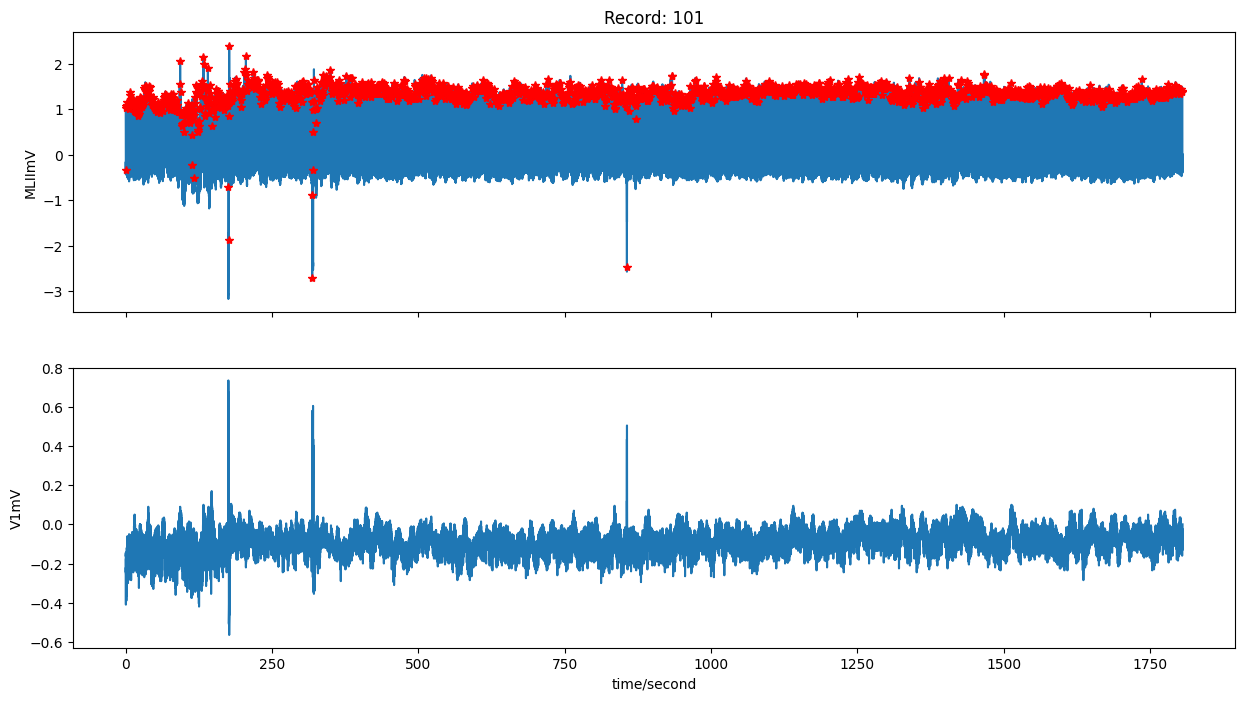

In [ ]:
# Sample to plot
sample = 1
# Check if the loading worked properly by plotting a signal
wfdb.plot_wfdb(record=dataset.iloc[sample]["Record"], annotation=dataset.iloc[sample]["Annotation"], time_units='seconds',figsize=(15,8))

## Implementation of the Pan Tompkins Algorithm
Original code of Antimattercorrade at https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection

In [ ]:
class Pan_Tompkins_QRS():

  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds.

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()

    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12]

    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal):
    '''
    Derivative Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*annotation.fs)/8

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * annotation.fs)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum

    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned.
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    global der
    der = self.derivative(bpass.copy())

    # Squaring Function
    global sqr
    sqr = self.squaring(der.copy())

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqr.copy())

    return mwin

## Applying the Pam Tompkins on the raw ECG
This might take around 10 minutes to execute (Maybe we should save the data afterwards?)

In [ ]:
QRS_detector = Pan_Tompkins_QRS()

def process_row(row):
    record = row["Record"]
    annotation = row["Annotation"]
    ecg_upper = pd.DataFrame(np.array([list(range(len(record.adc()))), record.adc()[:, 0]]).T, columns=['TimeStamp', 'ecg'])
    ecg_lower = pd.DataFrame(np.array([list(range(len(record.adc()))), record.adc()[:, 1]]).T, columns=['TimeStamp', 'ecg'])
    ecg_upper_processed = QRS_detector.solve(ecg_upper)
    ecg_lower_processed = QRS_detector.solve(ecg_lower)
    return {"Upper": ecg_upper_processed, "Lower": ecg_lower_processed, "Annotation": annotation}

processed_data = dataset.apply(process_row, axis=1, result_type='expand')

In [ ]:
processed_data.head()

,Upper,Lower,Annotation
0,"[0.0, 0.00027937775048695555, 0.01815955378165...","[0.0, 0.00031177346619761626, 0.02026527530284...",<wfdb.io.annotation.Annotation object at 0x7f6...
1,"[0.0, 0.0001981376617124158, 0.012878948011307...","[0.0, 0.00032666557788868034, 0.02123326256276...",<wfdb.io.annotation.Annotation object at 0x7f6...
2,"[0.0, 0.00029203816112083645, 0.01898248047285...","[0.0, 0.00020670847779289414, 0.01343605105653...",<wfdb.io.annotation.Annotation object at 0x7f6...
3,"[0.0, 0.00017824947617666885, 0.01158621595148...","[0.0, 0.0001146248717389398, 0.007450616663031...",<wfdb.io.annotation.Annotation object at 0x7f6...
4,"[0.0, 0.00024870115860068954, 0.01616557530904...","[0.0, 0.0003206625784722732, 0.020843067600697...",<wfdb.io.annotation.Annotation object at 0x7f6...


## Comparing the data of the first sensor

Text(0.5, 1.0, 'R Peak Locations')

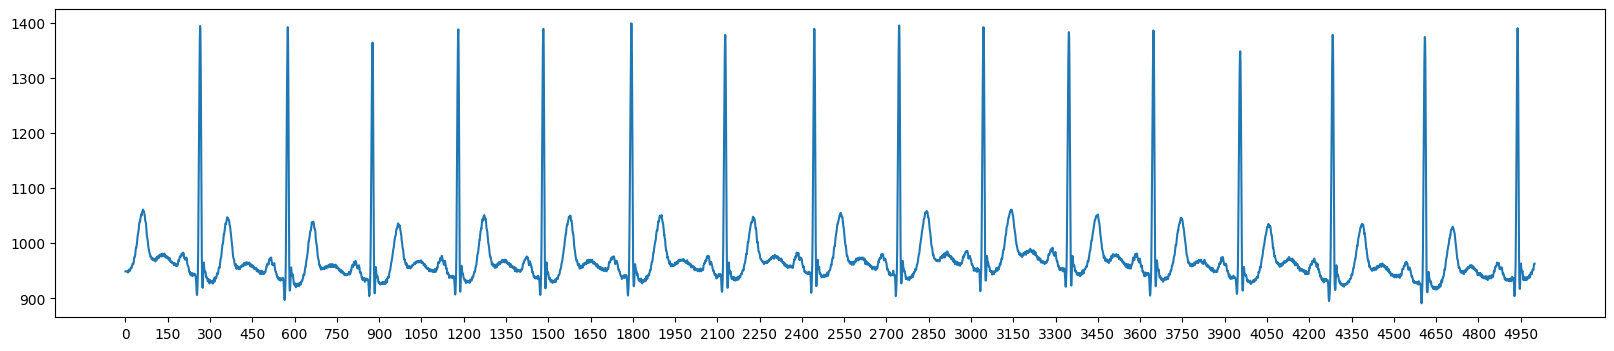

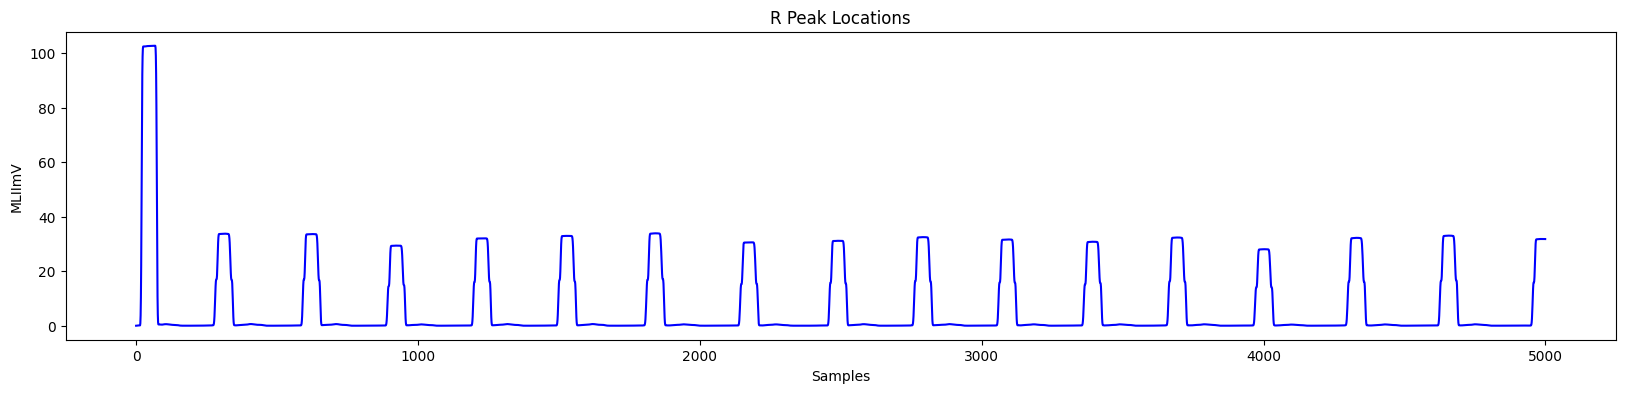

In [ ]:
# For comparison
sample = 3
slice_start = 0
slice_end = 5000
ecg = pd.DataFrame(np.array([list(range(len(dataset.iloc[sample]["Record"].adc()))),dataset.iloc[sample]["Record"].adc()[:,0]]).T,columns=['TimeStamp','ecg'])
raw_plot = ecg[slice_start:slice_end]["ecg"]

plt.figure(figsize = (20,4), dpi=100)
plt.xticks(np.arange(0, len(raw_plot)+1, 150))
plt.plot(raw_plot)

# Plotting function obtained form antimatter comrade
signal = processed_data.iloc[sample]["Upper"][slice_start:slice_end]
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(signal, color = 'blue')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

In [ ]:
# See the labels that we working with
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [ ]:
# Check how annotations work
len(processed_data.iloc[7]["Annotation"].symbol)
# print(len(processed_data.iloc[0]["Signal"]))

2140

## Trying out ChatGPT code to see how annotations work

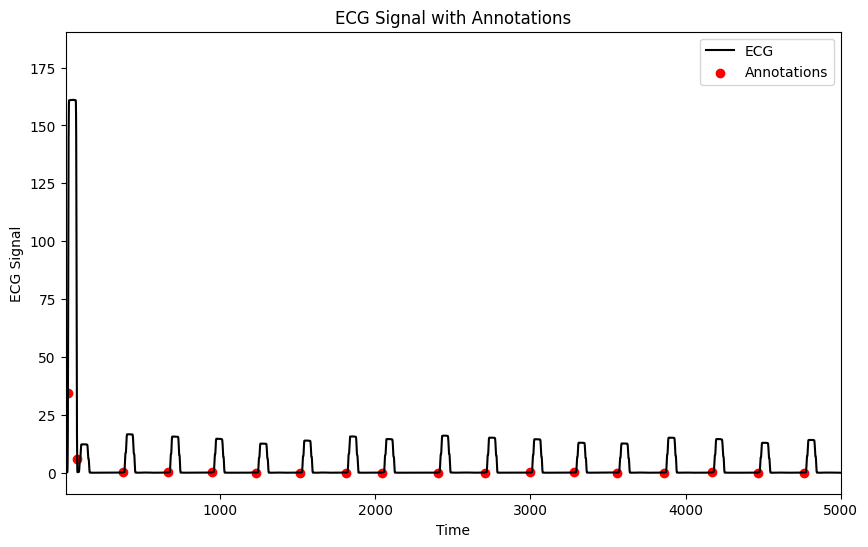

In [ ]:
def plot_segment(ecg_signal, annotations, start_time, end_time):
    ecg_df = pd.DataFrame(ecg_signal, columns=['ecg'])
    plt.figure(figsize=(10, 6))
    plt.plot(ecg_df.index, ecg_df['ecg'], color='black', label='ECG')
    plt.scatter(annotations.sample, ecg_df.loc[annotations.sample]['ecg'], color='red', label='Annotations')
    plt.xlabel('Time')
    plt.ylabel('ECG Signal')
    plt.title('ECG Signal with Annotations')
    plt.xlim(start_time, end_time)  # Set the x-axis limits to the desired time range
    plt.legend()
    plt.show()

# Select a record index to visualize
record_index = 0
record = processed_data.loc[record_index]
ecg_signal = record['Upper']
annotations = record['Annotation']

# Specify the desired segment start and end times (in seconds)
start_time = 3
end_time = 5000

# Plot the desired segment of the ECG signal with annotations
plot_segment(ecg_signal, annotations, start_time, end_time)



In [ ]:
# Inspect the sample indices of the annotations
print(annotations.sample)


[    18     77    370 ... 649484 649734 649991]


In [ ]:
print(dir(annotations))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ann_len', 'apply_range', 'aux_note', 'calc_cl_bytes', 'calc_core_bytes', 'calc_fs_bytes', 'chan', 'check_field', 'check_field_cohesion', 'check_fields', 'compact_fields', 'contained_labels', 'convert_label_attribute', 'create_label_map', 'custom_labels', 'description', 'extension', 'fs', 'get_available_label_stores', 'get_contained_labels', 'get_custom_label_attribute', 'get_label_fields', 'get_undefined_label_stores', 'label_store', 'num', 'record_name', 'rm_attributes', 'sample', 'set_label_elements', 'standardize_custom_labels', 'subtype', 'sym_to_aux', 'symbol', 'wr_ann_file', 'wrann']


In [ ]:
def get_annotations_with_times(ecg_signal, annotations, n,  start_time=None, end_time=None):

    for ann_sample, ann_symbol in zip(annotations.sample, annotations.symbol):
        if ann_sample >= start_time and ann_sample <= end_time:
            print(ann_sample, end = '')
            print(" ==> ", end = '')
            print(ann_symbol)
            k = ann_sample - n
            n = ann_sample
            print(k)


# Select a record index to visualize
record_index = 47
record = processed_data.loc[record_index]
ecg_signal = record['Upper']
annotations = record['Annotation']

# Specify the start and end time (in seconds)
start_time = 0
end_time = 5000

# Plot the ECG signal with annotations within the specified time range
get_annotations_with_times(ecg_signal, annotations, 0, start_time, end_time)





52 ==> +
52
135 ==> N
83
366 ==> N
231
606 ==> N
240
841 ==> N
235
1082 ==> N
241
1327 ==> N
245
1562 ==> N
235
1794 ==> N
232
2042 ==> N
248
2289 ==> N
247
2528 ==> N
239
2759 ==> N
231
2994 ==> N
235
3227 ==> N
233
3463 ==> N
236
3704 ==> N
241
3938 ==> N
234
4166 ==> N
228
4400 ==> N
234
4646 ==> N
246
4880 ==> N
234


from https://arxiv.org/pdf/1812.07421v2.pdf

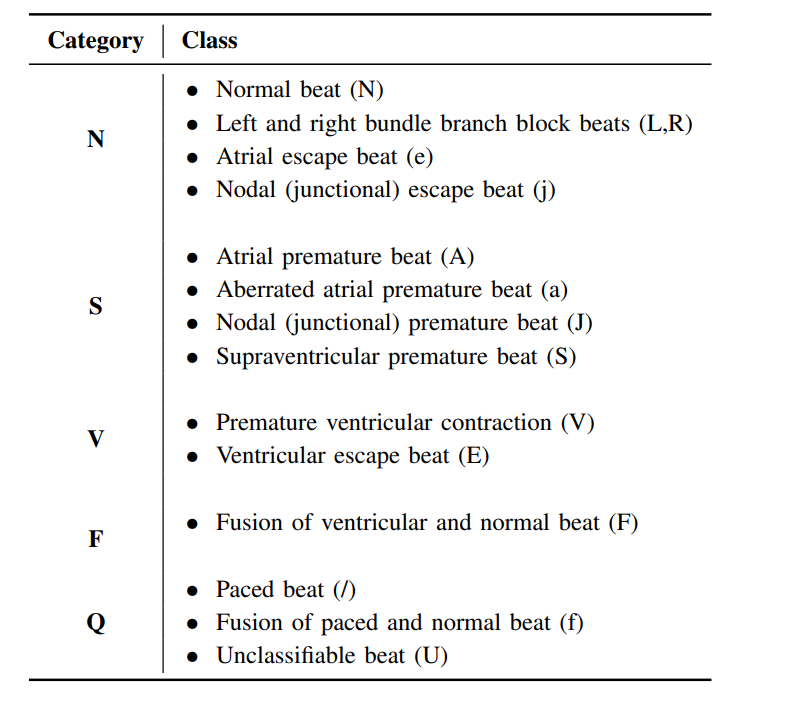

## Segmenting the Data
We can look at the annotation file for the presence of heart beats and split all heart beats for training. We should look at 100 units before the beat and 87 after to get 188 beats

In [ ]:
print(len(processed_data.iloc[0]["Annotation"].symbol))
print(len(processed_data.iloc[0]["Annotation"].sample))

2274
2274


In [ ]:
from sklearn import preprocessing
from scipy import signal
import gc

# Considerable amount of code used from https://github.com/koen-aerts/ECG_ML/blob/master/02_import_mitdb_data.ipynb
def extract_segments(time_series, annotation, beats_before, beats_after):

    scaler = preprocessing.StandardScaler()

    segments = []

    # Iterate over each point of interest in the annotation file
    for index, label in zip(annotation.sample, annotation.symbol):

        # Calculate the start and end positions of the segment
        start_position = max(0, index - beats_before)
        end_position = min(len(time_series), index + beats_after + 1)

        # Extract the segment from the time series
        segment = time_series[start_position:end_position]

        # Calculate the amount of padding needed
        padding_size = beats_before + beats_after + 1 - len(segment)

        # Pad the array with zeros
        segment = np.pad(segment, (0, padding_size), mode='constant', constant_values=(0.0, 0.0)).tolist()

        # Add the segment along with the point of interest label to the list
        segments.append([label] + segment)


    # Remove the first and last element to ensure consistency
    segments.pop(0)
    segments.pop(-1)

    return segments

In [ ]:
beats_before = 100
beats_after = 87

segmented_data = []

for index, row in processed_data.iterrows():
  upper_segments = extract_segments(row["Upper"], row["Annotation"], beats_before, beats_after)
  lower_segments = extract_segments(row["Lower"], row["Annotation"], beats_before, beats_after)
  segmented_data += upper_segments
  segmented_data += lower_segments

segmented_dataframe = pd.DataFrame(segmented_data)

In [ ]:
segmented_dataframe.rename(columns={0: "label"}, inplace=True)

In [ ]:
segmented_dataframe.head(10)

,label,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,N,0.000000,0.000002,0.000113,0.000286,0.000496,0.000669,0.000781,0.000843,0.000871,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,N,0.000787,0.000651,0.000529,0.000409,0.000285,0.000176,0.000100,0.000057,0.000038,...,0.282301,0.179123,0.095651,0.041477,0.014015,0.004110,0.002143,0.002103,0.001890,0.001397
2,N,0.000299,0.000219,0.000162,0.000121,0.000092,0.000071,0.000055,0.000046,0.000041,...,0.280127,0.162967,0.074753,0.025802,0.006673,0.002383,0.002210,0.002015,0.001539,0.001179
3,N,0.000447,0.000355,0.000286,0.000229,0.000182,0.000149,0.000130,0.000116,0.000107,...,0.271058,0.158764,0.073146,0.025211,0.006335,0.002099,0.001933,0.001693,0.001119,0.000675
4,N,0.000219,0.000150,0.000082,0.000030,0.000005,0.000000,0.000004,0.000013,0.000017,...,0.210199,0.107096,0.041355,0.011095,0.002212,0.001165,0.001146,0.000787,0.000399,0.000194
5,N,0.001889,0.001505,0.001147,0.000838,0.000592,0.000423,0.000334,0.000300,0.000291,...,0.195210,0.097295,0.037200,0.010677,0.003443,0.002797,0.002715,0.002142,0.001496,0.001084
6,N,0.000279,0.000279,0.000280,0.000280,0.000279,0.000274,0.000263,0.000249,0.000238,...,0.249532,0.140271,0.062405,0.020905,0.005279,0.001931,0.001802,0.001648,0.001282,0.001003
7,A,0.000772,0.001046,0.001292,0.001506,0.001669,0.001772,0.001835,0.001869,0.001881,...,0.241471,0.134210,0.058463,0.018600,0.003938,0.000933,0.000836,0.000693,0.000388,0.000183
8,N,0.000265,0.000267,0.000267,0.000270,0.000283,0.000297,0.000308,0.000319,0.000328,...,0.345743,0.235669,0.136221,0.065137,0.025212,0.008731,0.004635,0.004394,0.004189,0.003367
9,N,0.000447,0.000299,0.000178,0.000091,0.000038,0.000015,0.000009,0.000009,0.000009,...,0.201015,0.101618,0.039519,0.011254,0.003047,0.002199,0.002129,0.001557,0.000962,0.000617


In [ ]:
segmented_dataframe.loc[(segmented_dataframe[1] > 1)]

,label,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
4703,N,1.143641,1.216037,1.254812,1.252149,1.240201,1.249561,1.278293,1.297452,1.268379,...,2.889017,2.101775,1.490968,1.072104,0.799667,0.616604,0.482913,0.380006,0.301478,0.243782
4913,~,5.007067,2.873207,1.558177,0.851283,0.519969,0.390850,0.347150,0.327124,0.308878,...,0.090974,0.078852,0.072701,0.072474,0.072618,0.070446,0.066781,0.064313,0.065577,0.068773
6785,~,1.104857,0.766941,0.498511,0.316009,0.207039,0.150725,0.125585,0.113957,0.106338,...,0.026996,0.026481,0.025544,0.024387,0.023216,0.022052,0.020944,0.019961,0.019109,0.018339
8288,/,168.286906,168.304513,168.314614,168.319492,168.321274,168.321519,168.321527,168.321530,168.321668,...,2.771956,2.555905,2.264406,1.903645,1.499166,1.096224,0.745024,0.482411,0.317511,0.231324
8386,+,10.759169,10.772536,10.781586,10.788267,10.794788,10.802382,10.811078,10.819997,10.827739,...,0.015254,0.015561,0.016298,0.017254,0.017937,0.017944,0.017401,0.017150,0.017931,0.019769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224537,N,1.162179,1.220880,1.337961,1.467880,1.563527,1.610713,1.623229,1.622087,1.621390,...,2.616583,2.316070,1.861154,1.351530,0.906163,0.606666,0.463675,0.427284,0.431590,0.432478
224539,N,2.909497,2.908684,2.867530,2.731568,2.471720,2.123131,1.792665,1.590938,1.535674,...,3.701730,3.193749,2.416325,1.567694,0.880639,0.479731,0.331579,0.311953,0.310452,0.285873
224563,~,4.917756,4.915062,4.915323,4.918546,4.920605,4.919328,4.916550,4.915272,4.915368,...,0.103104,0.102224,0.101773,0.101773,0.101709,0.101167,0.100471,0.100483,0.101697,0.103175
224960,V,5.551298,5.504244,5.377648,5.116545,4.690328,4.135415,3.569094,3.142106,2.940646,...,4.955489,4.816409,4.685533,4.559576,4.438448,4.324844,4.218359,4.114241,4.006825,3.887983


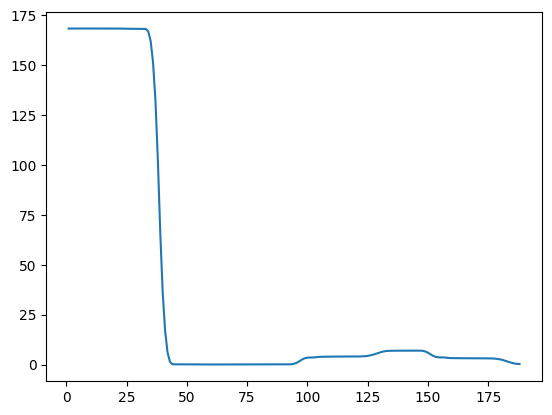

In [ ]:
plt.plot(segmented_dataframe.iloc[8288][1:])
plt.show()

## Splitting the data and saving it

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(segmented_dataframe, test_size=0.2, random_state=42)

# Save the training set to CSV
train_df.to_csv('train_data.csv', index=False)

# Save the testing set to CSV
test_df.to_csv('test_data.csv', index=False)

## Conclusion
This notebooks performs pre-processing and segments the data. Listed below are the csv files for training and testing

Train - https://drive.google.com/file/d/1xQ9aRWHQX6PY50i4aVtDWQ8bj65Whv9F/view?usp=sharing

Test - https://drive.google.com/file/d/1AAWfhiD-FZIP543VvOhfrlUVu5jECH6z/view?usp=sharing